In [1]:
%cd /home/mrearle/repos/R2R-EnvDrop-ObjAttn/

/mnt-homes/kraken/mrearle/repos/R2R-EnvDrop-ObjAttn


In [6]:
%%capture cap

import sys

src_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/r2r_src'
if src_path not in sys.path:
    sys.path.append(src_path)

mattersim_path = '/home/mrearle/datasets/Matterport3DSimulator/build'
if mattersim_path not in sys.path:
    sys.path.append(mattersim_path)


In [7]:
import collections
import gzip
import json
import math
import pathlib
import time

import MatterSim
import numpy as np
from PIL import Image

In [17]:
!ls /home/mrearle/storage/img_features/landmark

rxr_landmarks_processed_val_seen.json  rxr_landmarks_val_seen_guide.jsonl


In [21]:
SILVER_LANDMARK_PATHS = [
    # 'rxr_landmarks_train_guide.jsonl.gz',
    '/home/mrearle/storage/img_features/landmark/rxr_landmarks_val_seen_guide.jsonl',
    # 'rxr_landmarks_val_unseen_guide.jsonl.gz'
]

OUTDIR = 'landmarks'
IMG_SIZE = 300  # Set the maximum dimension.


def read_jsonlines(paths):
  for path in paths:
    with open(path, 'r') as f:
      for line in f:
        l = json.loads(line)
        if not isinstance(l['landmark_angle_coords'][0], list):
            l['landmark_angle_coords'] = [l['landmark_angle_coords']]
        yield l


def init_sim(h_fov, v_fov):
  """Initialize the Matterport3D Simulator for a given field-of-view."""
  simulator = MatterSim.Simulator()
  simulator.setCameraVFOV(v_fov)
  # Calculate the appropriate image height and width for the field-of-view.
  # The provided IMG_SIZE will be the larger image dimension.
  if h_fov > v_fov:
    width = IMG_SIZE
    height = int(math.tan(v_fov / 2.0) * width / math.tan(h_fov / 2.0))
  else:
    height = IMG_SIZE
    width = int(math.tan(h_fov / 2.0) * height / math.tan(v_fov / 2.0))
  simulator.setCameraResolution(width, height)
  simulator.setDepthEnabled(False)
  simulator.initialize()
  return simulator

In [22]:
  # Cluster landmarks with the same fov for faster rendering.
landmarks = collections.defaultdict(list)
total = 0
for item in read_jsonlines(SILVER_LANDMARK_PATHS):
    for i, (heading, pitch, hfov, vfov) in enumerate(item['landmark_angle_coords']):
        total += 1
        landmarks[(hfov, vfov)].append(
          ((item['scan'], item['landmark_source_panos'][i], heading,
            pitch), item['split'], item['language'], item['instruction_id'], i,
           item['text_spans'][i]))

In [23]:
def get_one_landmark():
    # Start rendering using the Matterport3D simulator.
    count = 0
    for key in landmarks:
        hfov, vfov = key
        sim = init_sim(hfov, vfov)
        for (scan, pano, heading, pitch), split, lang, instr_id, ix, landmark_phrase in landmarks[key]:
            if 'en' not in lang:
                continue

            sim.newEpisode([scan], [pano], [heading], [pitch])
            state = sim.getState()[0]
            yield Image.fromarray(np.array(state.rgb, copy=False)[:, :, ::-1]), scan, pano, heading, pitch, landmark_phrase
            count += 1

In [24]:
import matplotlib.pyplot as plt

In [25]:
getter = get_one_landmark()

In [36]:
im, scan, pano, heading, pitch, landmark_phrase = next(getter)

-1.8584073781967163 -0.6981316804885864 stairs


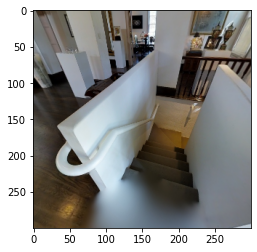

In [91]:
im, scan, pano, heading, pitch, landmark_phrase = next(getter)

print(heading, pitch, landmark_phrase)

plt.imshow(im)
plt.show()